This notebook file includes the application of pix2pix network (Isola et al. 2017) with the default network architecture
The workflow contains the following:
- Mounting of google drive (the training data stored there)
- Importing necessary packages (assuming the are installed already)
- Training pix2pix network on the training data, (leaving 300 for validation)
- Exporting the results in order of: scanned image (input), labels image (ground truth) and prediction

In [1]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
#mount your google drive for this notebook, it will ask for authorization
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
import os
os.chdir('/content/gdrive/My Drive/dl_final3')
!ls

dl_final_project_2.ipynb      in	outs
dl_final_project_2_old.ipynb  labels_2	outs3


In [ ]:
#!unzip -q my_images_.zip
#!ls

In [5]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-31ew7fwh
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-31ew7fwh
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=05e598d796df0bd8441199bd4e3965962ffc83d2d6a3c4689ead00d0f4a568b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-_wrolvms/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
### Visualize the data ###
# https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
%matplotlib inline
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

from __future__ import print_function, division
import scipy
from keras.datasets import mnist
from keras.utils import to_categorical
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
#from data_loader import DataLoader

In [7]:
ids_x_data = next(os.walk("in"))[2]
ids_y_data = next(os.walk("labels_2"))[2]
print(len(ids_x_data))
print(len(ids_y_data))

2803
2803


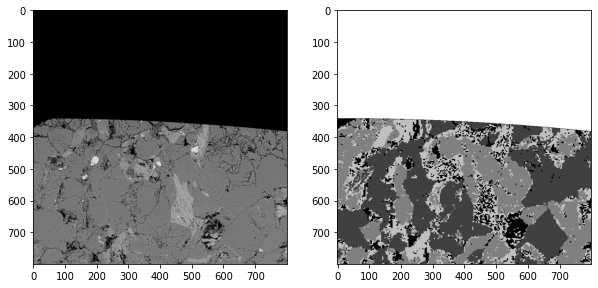

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
im_in = skimage.img_as_ubyte(io.imread('in/img1_Q1_r0_c0.png'))
plt.imshow(im_in,"gray")
plt.subplot(1,2,2)
im_out = skimage.img_as_ubyte(io.imread('labels_2/img1_Q1_r0_c0.png'))
plt.imshow(im_out,"gray")

In [9]:
print("im in shape",im_in.shape)
print("im out shape",im_out.shape)

im in shape (800, 800)
im out shape (800, 800)


In [ ]:
"""
import tensorflow.keras.backend as K
#import keras.backend as K
def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y
    
def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def iou(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
"""    

In [ ]:
def my_iou(y_true, y_pred, smooth=1.0):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_true_f * y_pred_f).sum()
    return (intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() - intersection + smooth)
def my_iou_per_class(y_true, y_pred, smooth=1.0):
  iou_all=[]
  print(y_true.shape[-1])
  for n in range(y_true.shape[-1]):
      y_true_f = y_true[:,:,:,n].flatten()
      y_pred_f = y_pred[:,:,:,n].flatten()
      intersection = (y_true_f * y_pred_f).sum()
      iou = (intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() - intersection + smooth)
      iou_all.append(iou)
  return iou_all

In [ ]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.reso = 768
        self.img_rows = self.reso
        self.img_cols = self.reso
        self.channels = 1
        self.classes = 5
        self.input_shape = (self.img_rows, self.img_cols, self.channels)
        self.output_shape = (self.img_rows, self.img_cols, self.classes)
        
        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)
        # Number of filters in the first layer of G and D
        self.gf = 32 #64 each
        self.df = 32
        optimizer = Adam(0.0002, 0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

        #-------------------------------------------
        # Construct Computational Graph of Generator
        #-------------------------------------------
        # Build the generator
        self.generator = self.build_generator()
        # Input images and their conditioning images
        img_A = Input(shape=self.output_shape)
        img_B = Input(shape=self.input_shape)
        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])
        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.input_shape)
        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)
        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.classes, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)
        #output_img2 = Conv2D(self.channels, kernel_size=1, strides=1, padding='same', activation='tanh')(output_img)
        #emre mode
        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.output_shape)
        img_B = Input(shape=self.input_shape)
        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])
        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)
        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):
        start_time = datetime.datetime.now()
        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i in range(len(ids_x_data)-300): #last 300 for test
            #for batch_i in range(X_train.shape[0]):             #for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                imgs_B = img_to_array(load_img("in/"+ids_x_data[batch_i], color_mode="grayscale", target_size=(self.reso, self.reso), interpolation='bilinear'))
                imgs_A = img_to_array(load_img("labels_2/"+ids_x_data[batch_i], color_mode="grayscale", target_size=(self.reso, self.reso), interpolation='nearest'))
                imgs_A = to_categorical(np.round(imgs_A/64), num_classes=self.classes)  
                imgs_B = imgs_B/255.0
                imgs_A = np.resize(imgs_A, [1,self.reso,self.reso,self.classes])
                imgs_B = np.resize(imgs_B, [1,self.reso,self.reso,1])
                # ---------------------
                #  Train Discriminator
                # ---------------------
                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)
                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------
                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                if batch_i % sample_interval == 0:
                  print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch+1, epochs,
                                                                        batch_i, len(ids_x_data)-300, #batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1], g_loss[0], elapsed_time))

                # #If at save interval => save generated image samples
                #if batch_i % sample_interval == 0:
                #    self.sample_images(epoch, batch_i) ##this function is moved to the very bottom, not necessary for the time being.

In [ ]:
gan = Pix2Pix()

In [17]:
gan.train(epochs=75, batch_size=1, sample_interval=500)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 1/75] [Batch 0/2503] [D loss: 2.161958, acc:  28%] [G loss: 62.807468] time: 0:00:09.651245
[Epoch 1/75] [Batch 500/2503] [D loss: 0.247349, acc:  63%] [G loss: 18.464186] time: 0:08:28.964426
[Epoch 1/75] [Batch 1000/2503] [D loss: 0.020698, acc:  99%] [G loss: 21.125055] time: 0:18:36.978140
[Epoch 1/75] [Batch 1500/2503] [D loss: 0.039444, acc:  97%] [G loss: 8.569111] time: 0:27:36.129014
[Epoch 1/75] [Batch 2000/2503] [D loss: 0.015937, acc: 100%] [G loss: 18.341005] time: 0:36:19.775485
[Epoch 1/75] [Batch 2500/2503] [D loss: 0.006689, acc: 100%] [G loss: 19.076071] time: 0:44:40.457864
[Epoch 2/75] [Batch 0/2503] [D loss: 0.011841, acc:  99%] [G loss: 17.401409] time: 0:44:42.206991
[Epoch 2/75] [Batch 500/2503] [D loss: 0.009499, acc:  99%] [G loss: 16.643293] time: 0:46:33.385905
[Epoch 2/75] [Batch 1000/2503] [D loss: 0.003755, acc: 100%] [G loss: 19.107710] time: 0:48:24.469089
[Epoch 2/75] [Batch 1500/2503] [D loss: 0.021054, acc:  99%] [G loss: 8.690306] time: 0:50:

KeyboardInterrupt: ignored

In [ ]:
# serialize model to JSON + # serialize weights to HDF5
model_json = gan.generator.to_json()
with open("/content/gdrive/My Drive/dl_final3/my_gen_768_old_full_data.json", "w") as json_file:
    json_file.write(model_json)
gan.generator.save_weights("/content/gdrive/My Drive/dl_final3/my_gen_768_old_full_data.h5")
print("Saved model to disk")

In [ ]:
# without loading images, get accuracy
%%capture
reso = 768
count = 0
good_x = []
good_y = []
good_p = []
my_iou_val = 0
iou_e = []
iou_p_c = []
plt.ioff()
for n, id_x, id_y in zip(range(len(ids_x_data)-300,len(ids_x_data)), ids_x_data, ids_y_data):
    x_img = img_to_array(load_img("in/"+id_x, target_size=(reso, reso), interpolation='bilinear', color_mode="grayscale"))
    x_img = x_img/255.0
    x_img = np.reshape(x_img,[1,reso,reso,1])
    y_img = img_to_array(load_img("labels_2/"+id_x, target_size=(reso, reso), interpolation='nearest', color_mode="grayscale")) 
    y_img = np.round(y_img/64).copy()
    y_img = to_categorical(y_img,num_classes=5)
    y_img = np.reshape(y_img,[1,reso,reso,5])
    predict = gan.generator.predict(x_img)
    #predict = model.predict(x_img)
    iou_curr = my_iou(y_img, predict)
    iou_cl_curr = my_iou_per_class(y_img, predict)
    y_img = y_img.argmax(axis=-1)
    predict = predict.argmax(axis=-1)
    iou_e.append(iou_curr)
    iou_p_c.append(iou_cl_curr)
    plt.figure(figsize=(30,90))
    plt.subplot(131)
    plt.imshow(x_img[0,:,:,0],"gray")
    plt.subplot(132)
    plt.imshow(y_img[0,:,:],"gray")
    plt.subplot(133)
    plt.imshow(predict[0,:,:],"gray")
    plt.savefig("/content/gdrive/My Drive/dl_final3/outs3/test_"+id_x)
    plt.close()    
    if (iou_curr > my_iou_val):
      good_x = x_img
      good_y = y_img
      good_p = predict
      my_iou_val = iou_curr  
    count = count+1
iou_e = np.array(iou_e,dtype=np.float32)
iou_p_c = np.array(iou_p_c,dtype=np.float32)

In [21]:
print("min iou {:.2f}".format(iou_e.min()))
print("max iou {:.2f}".format(iou_e.max()))
print("avg iou {:.2f}".format(iou_e.mean()))
print("std iou {:.2f}".format(iou_e.std()))

min iou 0.31
max iou 0.66
avg iou 0.50
std iou 0.06


In [23]:
np.set_printoptions(precision=2)
print("iou_e_pc min  ",(iou_p_c.min(axis=0)) )
print("iou_e_pc max  ",(iou_p_c.max(axis=0)) )
print("iou_e_pc mean ", (iou_p_c.mean(axis=0)) )
print("iou_e_pc std  ", (iou_p_c.std(axis=0)) )

iou_e_pc min   [ 9.43e-06 -5.55e-01 -1.62e+00 -1.69e+00 -1.90e-03]
iou_e_pc max   [ 1.09 16.64  6.12  1.39  0.83]
iou_e_pc mean  [0.32 0.71 0.44 0.37 0.17]
iou_e_pc std   [0.19 1.28 0.4  0.23 0.31]


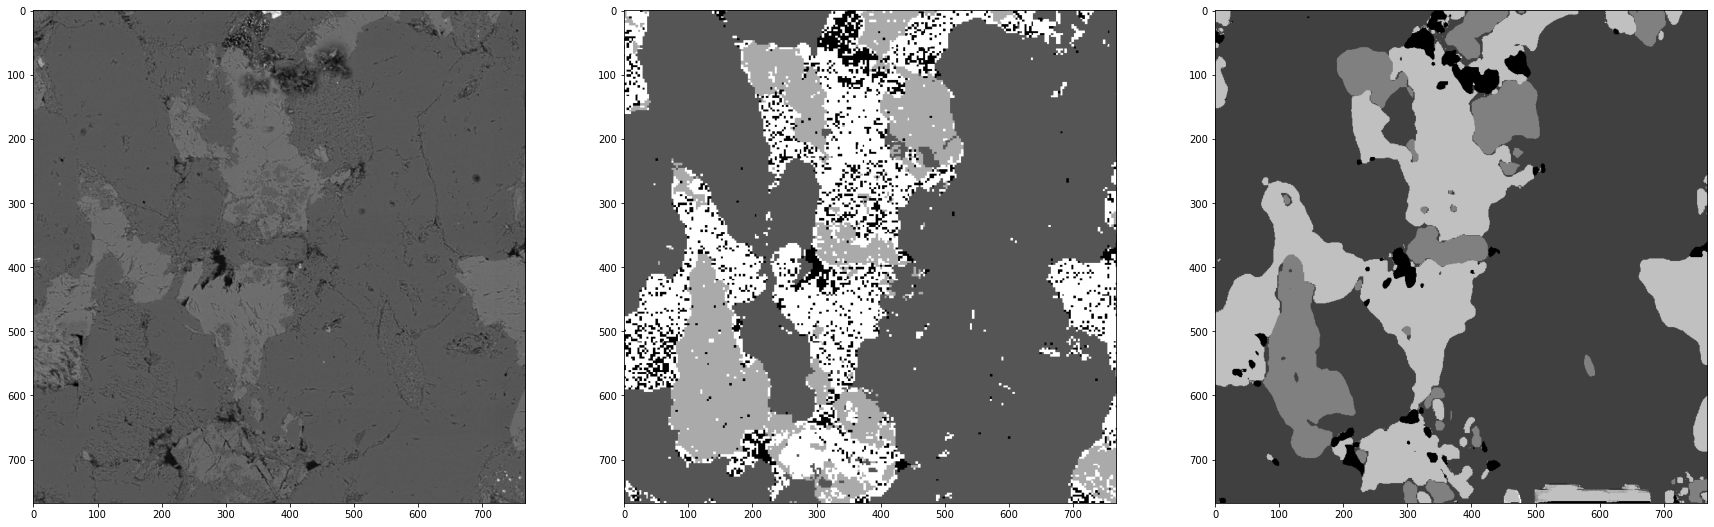

In [24]:
plt.figure(figsize=(30,90))
plt.subplot(131)
plt.imshow(good_x[0,:,:,0],"gray")
plt.subplot(132)
plt.imshow(good_y[0,:,:],"gray")
plt.subplot(133)
plt.imshow(good_p[0,:,:],"gray")

In [25]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun  4 20:20:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |   7717MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [26]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [27]:
!nvidia-smi

Thu Jun  4 20:20:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |   7717MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [28]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [29]:
!free -h --si | awk  '/Mem:/{print $2}'

26G


In [ ]:
#this part is to load the model, then you need to swap the lines in the evaluation cell above for prediction
from keras.models import model_from_json
# load json and create model
json_file = open('/content/gdrive/My Drive/dl_final2/my_gen_768_old_full_data.json', 'r')
model = json_file.read()
json_file.close()
model = model_from_json(model)
# load weights into new model
model.load_weights("/content/gdrive/My Drive/dl_final2/my_gen_768_old_full_data.h5")
print("Loaded model from disk")

In [ ]:
"""
acc = []
for n in (range(1000)):
  acc.append(calc_iou(x_Test_predict[n], y_test[n]))
acc = np.array(acc,dtype=np.float32)
"""

In [ ]:
"""
X_test = np.zeros((300, reso, reso, 1), dtype=np.float32)
y_test = np.zeros((300, reso, reso, 5), dtype=np.float32)
# Load images
count = 0
for n, id_x, id_y in zip(range(len(ids_x_data)-300,len(ids_x_data)), ids_x_data, ids_y_data):
    x_img = img_to_array(load_img("in/"+id_x, target_size=(reso, reso), interpolation='bilinear', color_mode="grayscale"))
    y_img = img_to_array(load_img("labels_2/"+id_x, target_size=(reso, reso), interpolation='nearest', color_mode="grayscale")) 
    X_test[count] = x_img/255.0
    a = np.round(y_img/64).copy()
    y_test[count] = to_categorical(a,num_classes=5)
    count = count+1
"""    

In [ ]:
"""
    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3

        imgs_A = X_train[128]
        imgs_B = y_train[128]
        imgs_A = np.resize(imgs_A, [1,256,256,3])
        imgs_B = np.resize(imgs_B, [1,256,256,3])
        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()

"""

In [ ]:
#X_data = np.zeros((len(ids_x_data)-minus, 256, 256, 3), dtype=np.float32)
#y_data = np.zeros((len(ids_y_data)-minus, 256, 256, 3), dtype=np.float32)
# Load images
#for n, id_x, id_y in zip(range(len(ids_x_data)-minus), ids_x_data, ids_y_data):
#    x_img = img_to_array(load_img("in_final/"+id_x, target_size=(256, 256), interpolation='bilinear'))
#    y_img = img_to_array(load_img("out_final/"+id_y, target_size=(256, 256), interpolation='nearest')) 
#    X_data[n] = x_img/255.0
#    y_data[n] = y_img/255.0
#plt.imshow(y_data[968])
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, shuffle=True)
#del X_data, y_data
#print(X_train.shape)